In [81]:
import random 
random.seed(5)

In [56]:
!pip install pip install mdlp-discretization

In [57]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
import pandas as pd
import pickle
import os
import numpy as np
from mdlp.discretization import MDLP
from sklearn.model_selection import train_test_split
os.chdir("D:\\GoogleDrive\\InterviewAssignment\\GoJekDriverAcceptanceGit\\GoJekAssignment")

In [59]:
dataset  = pd.read_csv("data\\processed\\dataset.csv")
dataset = dataset.sort_values(by='event_timestamp',ascending=True)
# dataset_train, dataset_test = train_test_split(dataset,test_size = 0.2)
dataset_train, dataset_test = dataset.head(int(len(dataset)*(80/100))),dataset.tail(int(len(dataset)*(20/100)))
dataset_train.to_csv("data\\processed\\dataset_train.csv")
dataset_test.to_csv("data\\processed\\dataset_test.csv")

In [60]:
df_train.head()

,event_timestamp,driver_id,participant_status,order_id,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy,trip_distance,pickup_latitude,pickup_longitude,is_accepted
234920,2015-05-10 00:00:11.845 UTC,288223322155,CREATED,257432374014,135546226388,-2.995167,104.767443,87.600,1.428,-2.994609,104.767860,0
234921,2015-05-10 00:00:12.963 UTC,288223322155,ACCEPTED,257432374014,135546226388,-2.995167,104.767443,87.600,1.428,-2.994609,104.767860,1
154995,2015-05-10 00:00:16.174 UTC,552835747248,CREATED,811842312011,291923492741,-2.932598,104.789056,4.348,2.501,-2.936892,104.792555,0
43210,2015-05-10 00:00:19.332 UTC,869163565780,CREATED,613128887100,495307579739,-2.919218,104.716482,3.000,5.212,-2.921464,104.717112,0
43218,2015-05-10 00:00:19.926 UTC,869163565780,ACCEPTED,613128887100,495307579739,-2.919218,104.716482,3.000,5.212,-2.921464,104.717112,1


In [61]:
df_test.head()

,event_timestamp,driver_id,participant_status,order_id,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy,trip_distance,pickup_latitude,pickup_longitude,is_accepted
138909,2015-05-17 00:44:15.535 UTC,975175489439,CREATED,163686816212,122202044916,-3.049367,104.791269,65.498,8.794,-3.052633,104.784256,0
396486,2015-05-17 00:44:16.311 UTC,834534674631,CREATED,504159469300,577377619828,-2.972423,104.768210,47.027,2.111,-2.970810,104.763938,0
219480,2015-05-17 00:44:19.085 UTC,438583926376,CREATED,804109560910,787828218534,-2.915970,104.768713,3.141,4.148,-2.914109,104.763749,0
219479,2015-05-17 00:44:19.701 UTC,438583926376,ACCEPTED,804109560910,787828218534,-2.915970,104.768713,3.141,4.148,-2.914109,104.763749,1
128826,2015-05-17 00:44:24.948 UTC,232102147092,CREATED,668295252801,926374391979,-2.966517,104.751583,4.068,2.059,-2.966897,104.748923,0


In [62]:
train  = pd.read_csv("data\\processed\\df_train.csv")
train_filtered = train[train["participant_status"] != "CREATED"]
train_filtered.loc[:,"event_timestamp"] = pd.to_datetime(train_filtered["event_timestamp"], infer_datetime_format=True).dt.tz_convert('Asia/Kolkata')
train_filtered.loc[:,"date"] = train_filtered.event_timestamp.dt.date
train_filtered.loc[:,"dayofweek"] = train_filtered.event_timestamp.dt.dayofweek
train_filtered.loc[:,"hourofday"] = train_filtered.event_timestamp.dt.hour
#train_filtered = train_filtered.sort_values(by = ['driver_id', 'date'])

<font size="4">  Mean aceeptance rate of rides for various day of week  in general seems to be same though on weekend it seems to fall </font>

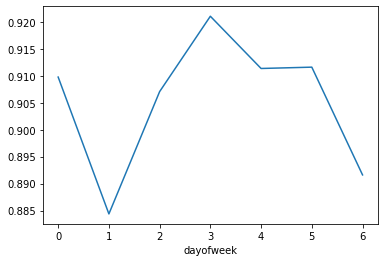

In [63]:
train_filtered.groupby("dayofweek")['is_accepted'].mean().plot()

<font size="4">Mean aceeptance rate of rides for different hours seems to vary especially during late night it drops signficantly</font>

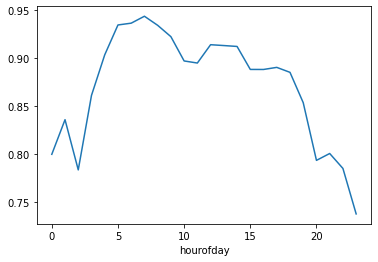

In [64]:
train_filtered.groupby("hourofday")['is_accepted'].mean().plot()

<font size="3"> Total Variance between the drivers behaviour in accepting rides on different timestamps we have to model this at driver level to find out which driver is more likely to accept given day, hour </font>

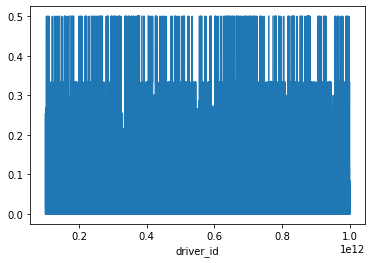

In [65]:
train_filtered.groupby("driver_id")["is_accepted"].var().plot()

In [66]:
train.event_timestamp.min(),train.event_timestamp.max()

('2015-05-10 00:00:11.845 UTC', '2015-05-17 00:44:08.139 UTC')

<font size="4"> Are there any drivers which are new in test ?? We will have to think about them while creating driver specific features </font>

<font size="4"> Creating General Participant Features </font>

In [67]:
dayofweek_average = train_filtered.groupby("dayofweek")['is_accepted'].mean().reset_index().rename(columns = {'is_accepted':'dayofweek_average'})
hourofday_average = train_filtered.groupby("hourofday")['is_accepted'].mean().reset_index().rename(columns = {'is_accepted':'hourofday_average'})

In [68]:
train_filtered = train_filtered.merge(dayofweek_average,on="dayofweek",how='right')\
                            .merge(hourofday_average,on="hourofday",how='right')

<font size="4"> Driver Specific Features </font>

In [69]:
driver_last5day_rolling_mean = train_filtered.groupby(['driver_id','date'])\
                                             .agg({'is_accepted':'mean'})\
                                             .groupby(level=0, group_keys=False)\
                                             .rolling(5, min_periods = 1)\
                                             .mean().reset_index()

driver_last5day_rolling_mean = driver_last5day_rolling_mean.rename(columns = {'is_accepted':'is_accepted_last5day_rolling_mean'})

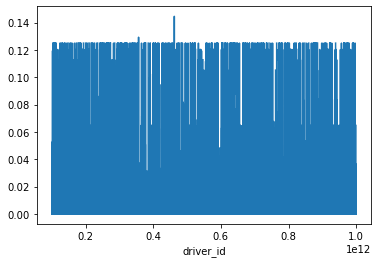

In [70]:
driver_last5day_rolling_mean.groupby("driver_id")['is_accepted_last5day_rolling_mean'].var().plot()

<font size="3"> Capturing variance in acceptance behaviour of different drivers on different day of week </font>

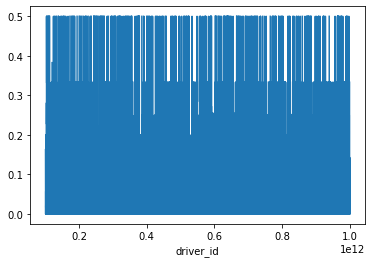

In [71]:
driver_last2dayofweek_average = train_filtered.groupby(["driver_id","date"],as_index=False)\
        .agg({'is_accepted': 'mean', 'dayofweek': 'first'}).reset_index()\
        .groupby(["driver_id","dayofweek"])["is_accepted"] \
        .apply(lambda x: x.tail(2).mean()).reset_index()

driver_last2dayofweek_average = driver_last2dayofweek_average.rename(columns= {'is_accepted':'driver_dayofweek_average'})

driver_last2dayofweek_average = driver_last2dayofweek_average.pivot('driver_id','dayofweek','driver_dayofweek_average').stack(dropna=False).reset_index(name='driver_dayofweek_average')

driver_last2dayofweek_average.groupby("driver_id")["driver_dayofweek_average"].var().plot()

driver_last2dayofweek_average['driver_dayofweek_average'].fillna(driver_last2dayofweek_average.groupby('driver_id')['driver_dayofweek_average'].transform('mean'),inplace = True)

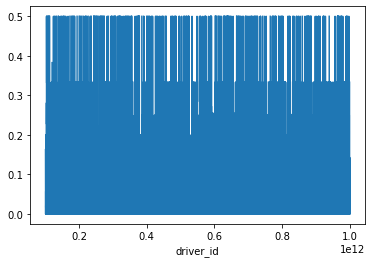

In [100]:
driver_last2dayofweek_median = train_filtered.groupby(["driver_id","date"],as_index=False)\
        .agg({'is_accepted': 'mean', 'dayofweek': 'first'}).reset_index()\
        .groupby(["driver_id","dayofweek"])["is_accepted"] \
        .apply(lambda x: x.median()).reset_index()

driver_last2dayofweek_median = driver_last2dayofweek_median.rename(columns= {'is_accepted':'driver_dayofweek_median'})

driver_last2dayofweek_median.groupby("driver_id")["driver_dayofweek_median"].var().plot()

driver_last2dayofweek_median = driver_last2dayofweek_median.pivot('driver_id','dayofweek','driver_dayofweek_median').stack(dropna=False).reset_index(name='driver_dayofweek_median')

driver_last2dayofweek_median['driver_dayofweek_median'].fillna(driver_last2dayofweek_median.groupby('driver_id')['driver_dayofweek_median'].transform('mean'),inplace = True)

In [103]:
xyz = driver_last2dayofweek_median.merge(driver_last2dayofweek_average,on=["driver_id","dayofweek"],how="inner")

In [104]:
xyz.columns

Index(['driver_id', 'dayofweek', 'driver_dayofweek_median',
       'driver_dayofweek_average'],
      dtype='object')

In [105]:
xyz.loc[xyz["driver_dayofweek_median"] != xyz["driver_dayofweek_average"]]

,driver_id,dayofweek,driver_dayofweek_median,driver_dayofweek_average


<font size="3"> Capturing variance in acceptance behaviour of different drivers on different hour of day </font>

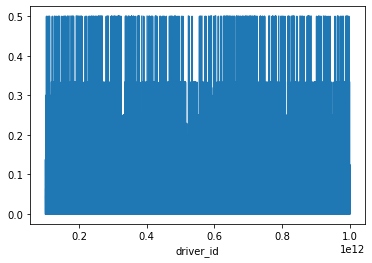

In [72]:
driver_hourofday_average = train_filtered.groupby(["driver_id","hourofday"],as_index=False).agg({'is_accepted': 'mean'}).rename(columns= {'is_accepted':'driver_hourofday_average'})
driver_hourofday_average = driver_hourofday_average.pivot('driver_id','hourofday','driver_hourofday_average').stack(dropna=False).reset_index(name='driver_hourofday_average')
driver_hourofday_average.groupby("driver_id")["driver_hourofday_average"].var().plot()
driver_hourofday_average['driver_hourofday_average'].fillna(driver_hourofday_average.groupby('driver_id')['driver_hourofday_average'].transform('mean'),inplace = True)

In [73]:
dayofweek_features = driver_last2dayofweek_average.merge(dayofweek_average,on="dayofweek",how="outer")
hourofday_features = driver_hourofday_average.merge(hourofday_average,on="hourofday",how="outer")
last5day_features = driver_last5day_rolling_mean

<font size="4">  Entropy based discretisation of hours on the basis of acceptance and number of request based binning on traffic volumne </font>

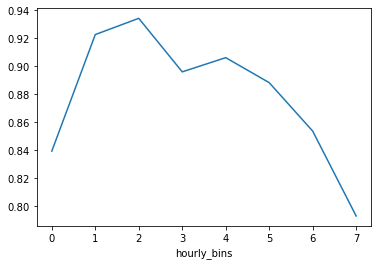

In [74]:
transformer = MDLP(continuous_features=[True])
train_filtered['hourly_bins'] = transformer.fit_transform(np.array(train_filtered['hourofday']).reshape(-1, 1), train_filtered['is_accepted'])
train_filtered.groupby('hourly_bins')['is_accepted'].mean().plot()
pickle.dump(transformer, open('transformer.pkl', 'wb'))

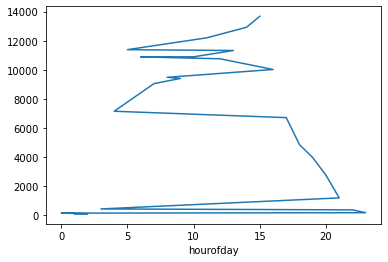

In [75]:
train_filtered.groupby('hourofday').size().sort_values(ascending=False).plot()
train_filtered["is_busy_hour"] = train_filtered["hourofday"].apply(lambda x:  1 if x>=5 and x<=15 else 0)

In [76]:
dayofweek_features.to_csv("data\\processed\\dayofweek_features_train.csv")
hourofday_features.to_csv("data\\processed\\hourofday_features_train.csv")
last5day_features.to_csv("data\\processed\\last5day_features_train.csv")

In [79]:
df_train[["driver_latitude","driver_longitude","pickup_latitude","pickup_longitude"]].to_csv("dataset_train_mahima.csv")
df_test[["driver_latitude","driver_longitude","pickup_latitude","pickup_longitude"]].to_csv("dataset_test_mahima.csv")